In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('fede'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import pandas as pd
from client import Client
from supported_modles import Supported_modles
import utils
from fedavg import Fedavg
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import random
from copy import deepcopy
import statistics
import matplotlib.pyplot as plt

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
selected_model = Supported_modles.NN_classifier

In [4]:
clients, test_x, test_y = utils.set_data_mock(selected_model, True, False)

Creating node1.
Creating node2.
Creating node3.
Creating node4.


In [5]:
test_y.sum()

35591.0

In [6]:
f1_before = []
for client in clients:
    client.init_empty_model(epochs=30)
    try:
        client.train_model(epochs=50)
    except ValueError:
        score = 0
        print(client.name)
        f1_before.append(score)
        continue 
    try: 
        score = client.test_model_f1(y_test=test_y, X_test=test_x)
    except IndexError:
        score = 0
    f1_before.append(score)
    print(score)

0.5414388370364253
0.22460665206134237
0.5759487602354882


In [7]:
fedavg = Fedavg("global", selected_model)

Waitiing for a Connection..


In [8]:
#clients.remove(clients[0])

In [9]:
###First learn model on clients:
def plot(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        round_scores = []
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            # X_train = client.x_chunks[0]
            # y_train = client.y_chunks[0]

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
        round_scores.append(score)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)

                # X_train = client.x_chunks[round + 1]
                # y_train = client.y_chunks[round + 1]
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            round_scores.append(score)
            # print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(round_scores)

    # print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    plt.xlabel("Number of Rounds", fontsize=16)
    plt.ylabel("F1-Score", fontsize=16)
    plt.xticks(range(0,rounds+1,5))
    plt.xticks(size = 16)
    plt.yticks(size = 16)
    plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    plt.show()


In [10]:
###First learn model on clients:
def find_scores(epochs, split, rounds):
    epochs = epochs
    split = split
    scores = []

    for _ in range(10):
        score = 0
        round_weights = []
        dataset_size = 0
        applicable_models = []
        first = True

        for client in clients:
            client.init_empty_model(epochs)
            X_train, X_test, y_train, y_test = client.split_data(split)

            client.train_model(X_train,y_train,epochs=epochs)
            dataset_size += client.x.shape[0]
            round_weights.append(dataset_size)
            applicable_models.append(client.model)
            if first:
                fedavg.init_global_model(client.model)
                first = False
            # print('.')

        round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size
        fedavg.update_global_model(applicable_models, round_weights, selected_model)

        score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)

        number_of_rounds = rounds
        max_score = 0
        optimal_model = None


        for round in range(number_of_rounds):

            applicable_clients = random.sample((clients), len(clients))
            applicable_models = []
            applicable_name = []
            round_weights = []
            dataset_size = 0
            

            for client in applicable_clients:
                # print(f'.', end='')

                X_train, X_test, y_train, y_test = client.split_data(split)
            
                dataset_size += X_train.shape[0]
                sample_weights = compute_sample_weight('balanced', y=y_train)

                client.load_global_model(fedavg.model)
                client.train_local_agent(X_train, y_train, epochs, sample_weights)
                round_weights.append(X_train.shape[0])
                applicable_models.append(client.model)


            round_weights = np.array(round_weights) / dataset_size
            fedavg.update_global_model(applicable_models, round_weights, selected_model)

            score = fedavg.test_model_f1(y_test=test_y, X_test=test_x)
            print(score, end=' ')
            if score > max_score:
                # print(score)
                max_score = score
                optimal_model = deepcopy(fedavg.model)
        print(score)
        print('--------------------')
        scores.append(score)

    print(f'epochs: {epochs} split = {split} --- {statistics.mean(scores)} stdev {statistics.stdev(scores)}')
    plt.rcParams["figure.figsize"] = (10,10)
    for x in scores:
        plt.plot(x)

    # plt.xlabel("Number of Rounds", fontsize=16)
    # plt.ylabel("F1-Score", fontsize=16)
    # plt.xticks(range(0,rounds+1,5))
    # plt.xticks(size = 16)
    # plt.yticks(size = 16)
    # plt.title('UNSW - LR-SGD, E=' +str(epochs)+', B=' + str(split) +', C=5')
    # plt.show()


In [12]:
# plot(10,0.9,19)

In [13]:
# plot(10,0.8,19)

In [14]:
# plot(20,0.9,9)

In [15]:
# plot(20,0.8,9)

0.5782131396723527 0.697026109538038 0.6151471793964921 0.641408247193509 0.6268950865614971 0.6268950865614971
--------------------
0.43030762018103785 0.19877845641310382 0.5262221291740814 0.5032031885812065 0.0 0.0
--------------------
0.6210001172787717 0.1746881368838324 0.5711035864591263 0.7241990360079387 0.7731368956362413 0.7731368956362413
--------------------
0.005938874415216965 0.5451059238155863 0.6979752732485218 0.4998841007270045 0.39228872450123287 0.39228872450123287
--------------------
0.0 0.41919970290595115 0.5552997620475517 0.6754538980006812 0.0 0.0
--------------------
0.0 0.0 0.0 0.010707879122395476 0.5225685598681252 0.5225685598681252
--------------------
0.0 0.5633216542389122 0.5441189628330619 0.7171580408218529 0.0 0.0
--------------------
0.0 0.6148493638966309 0.4703304258153225 0.0616255560048524 0.7206858122588942 0.7206858122588942
--------------------
0.5654242275625307 0.6027821254594377 0.6483410530295869 0.0 0.7747080345714253 0.77470803457

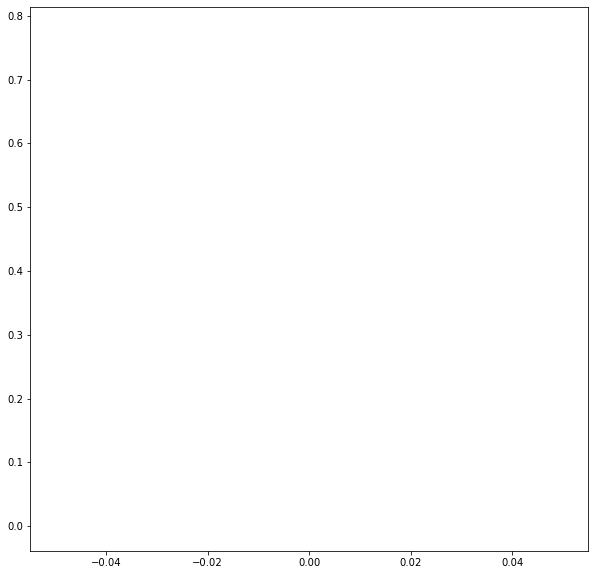

In [12]:
find_scores(10, 0.9, 5)